# SIC PROJECT



Import the dependencies and set the device

In [4]:
# requirements and dependencies
# check if the requirements are installed
requirements = [
    "tensorflow",
    "numpy",
    "matplotlib",
    "tensorboard",
    "tensorflow_hub",
    "sklearn",
]
# if not, quit
for requirement in requirements:
    try:
        __import__(requirement)
    except ImportError:
        print("one or more requirements are not installed")
        print("please install the requirements in the requirements.txt file")
        print("you can do this by running the following command in the terminal:")
        print("pip install -r requirements.txt")
        raise ImportError("Requirement not installed: {}".format(requirement))

print("All requirements are installed, you are good to go!")

All requirements are installed, you are good to go!


In [5]:
#import packages
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import warnings


%load_ext tensorboard
print("success")

success


In [6]:
# check devices available
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
tf.config.list_physical_devices()

/device:GPU:0
Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data Exploring and Processing

* Reading, processing, and augmenting all done by `ImageDataGenerator`

**Rapid EDA**

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
datagen = ImageDataGenerator()
train_ds = datagen.flow_from_directory("data/train")
print("classes: ", train_ds.class_indices)
imgs, labels = train_ds.next()

KeyboardInterrupt: 

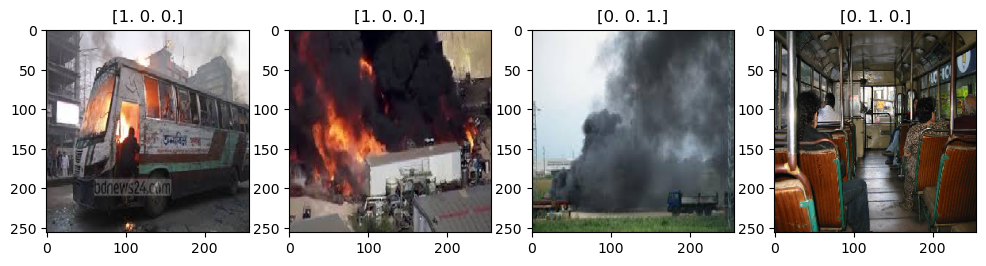

In [ ]:
# display random images from the dataset
fig, ax = plt.subplots(1, 4, figsize=(12, 9))
for i in range(4):
    idx = np.random.randint(0, len(imgs))
    ax[i].imshow(imgs[idx].astype("uint8"))
    ax[i].set_title(labels[idx])

**Processing and Augmenting Data**

In [ ]:
# only augmenting the training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=10.0,
    height_shift_range=10.0,
    shear_range=10,
    zoom_range=0.1,
    vertical_flip=True,
)

test_val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_ds = train_datagen.flow_from_directory("data/train", target_size=(224, 224))
val_ds = test_val_datagen.flow_from_directory("data/val", target_size=(224, 224))
test_ds = test_val_datagen.flow_from_directory("data/test", target_size=(224, 224))

Found 2295 images belonging to 3 classes.
Found 405 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


# Models building

In [ ]:
# built from scratch model
def get_builtFromScartchModel(IMG_SIZE=224, NUM_CLASSES=3, dropout_rate=0, lr=0.001):
    # model architecture
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(
                64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)
            ),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(NUM_CLASSES, activation="softmax"),
        ]
    )

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    # get model summary
    model.summary()

    return model

In [ ]:
def get_trained_model(url, inputShape=(224, 224, 3), trainModel=True, lr=0.001):
    "takes in the url of the tensorflow_hub  model and the input shape and the train option, returns the trained model attached to a classification head"
    feature_extractor_layer = hub.KerasLayer(
        url, input_shape=inputShape, trainable=trainModel
    )

    model = tf.keras.Sequential(
        [
            feature_extractor_layer,
            tf.keras.layers.Dense(3, activation="softmax"),  # smoke, normal, fire
        ]
    )

    # compile the model
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()],
    )

    # display the model summary
    model.summary()

    return model

In [ ]:
def evaluate(model, fitHistory, test_data):
    """
    Test the model on the test data and print the accuracy, confusion matrix and classification report.

    Args:
        model: A Keras model.
        fitHistory: A Keras History object returned by the `fit` method.
        test_data: A keras dataset object.

    """
    # convert test_data to numpy array
    y = np.concatenate([test_data.next()[1] for i in range(test_data.__len__())])

    # predict
    predictions = model.predict(test_data)
    predictions = np.argmax(predictions, axis=1)
    test_labels = np.argmax(y, axis=1)
    print("-" * 50)
    # print accuracy
    print(
        "Accuracy: "
        + str(accuracy_score(test_labels, predictions))
        + "\n"
        + "while fitting the model, the accuracy was: \n"
        + str(fitHistory.history["categorical_accuracy"][-1])
        + " in the train data"
        + "\n"
        + str(fitHistory.history["val_categorical_accuracy"][-1])
        + " in the validation data"
    )
    # print confusion matrix
    print("-" * 50)
    print("Confusion matrix:\n" + str(confusion_matrix(test_labels, predictions)))
    print("-" * 50)
    # print classification report
    print(
        "Classification report:\n"
        + str(
            classification_report(
                test_labels, predictions, labels=["Fire", "Neutral", "Smoke"]
            )
        )
    )

# Train & Hyperparameter tuning

**1.0 Build multiple `FromScratch Model` with different hyperparameters**

In [ ]:
# load model
model = get_builtFromScartchModel()

# some parameters
EPOCHS = 10
IMG_SIZE = 224
BATCH_SIZE = 100

# for tensorboard
log_dir = (
    "logs/fit/" + str(len(os.listdir("logs/fit")) + 1)
    if os.path.exists("logs/fit")
    else "logs/fit/1"
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

historyFit = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tensorboard_callback],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 54, 54, 128)       0         
                                                                 
 flatten (Flatten)           (None, 373248)            0

KeyboardInterrupt: 

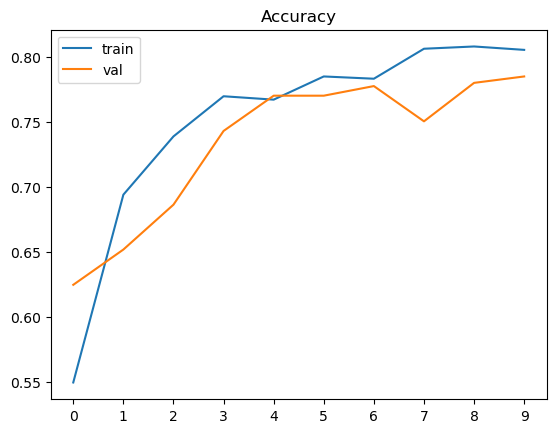

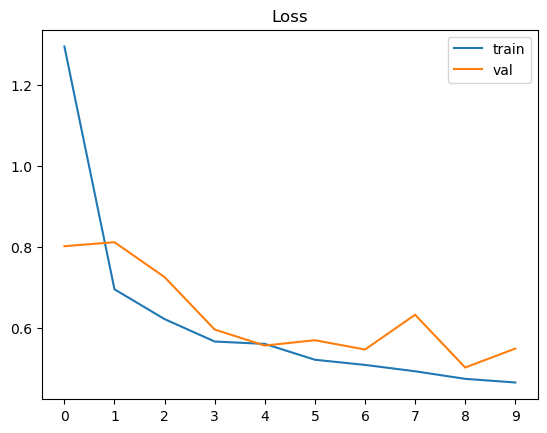

In [ ]:
plt.plot(historyFit.history["categorical_accuracy"], label="train")
plt.plot(historyFit.history["val_categorical_accuracy"], label="val")
plt.xticks(np.arange(10))
plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(historyFit.history["loss"], label="train")
plt.plot(historyFit.history["val_loss"], label="val")
plt.xticks(np.arange(10))
plt.title("Loss")
plt.legend()
plt.show()

**1.1 Search for Best Learning rate**

In [ ]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = get_builtFromScartchModel(lr=lr)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    scores[lr] = history.history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 54, 54, 128)       0         
                                                                 
 flatten_2 (Flatten)         (None, 373248)           

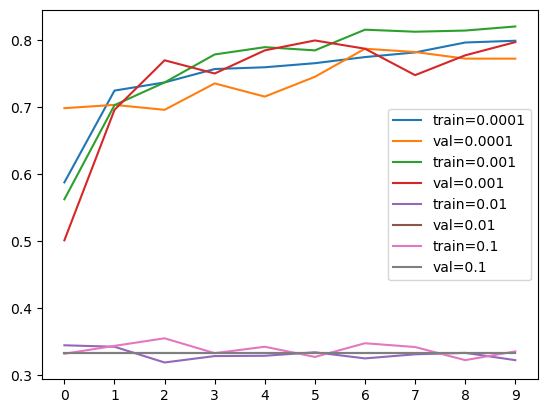

In [ ]:
for lr, hist in scores.items():
    plt.plot(hist["categorical_accuracy"], label=(f"train={lr}"))
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={lr}"))

plt.xticks(np.arange(10))
plt.legend()

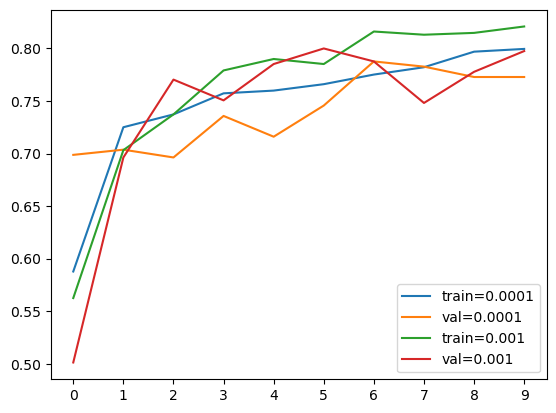

In [ ]:
# remove poor scores to see better
del scores[0.1]
del scores[0.01]

for lr, hist in scores.items():
    plt.plot(hist["categorical_accuracy"], label=(f"train={lr}"))
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={lr}"))

plt.xticks(np.arange(10))
plt.legend()

**1.2 Search for best dropout rate**

In [ ]:
learning_rate = 0.001  # best lr so far
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    model = get_builtFromScartchModel(lr=learning_rate, dropout_rate=droprate)
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)
    scores[droprate] = history.history

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 111, 111, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 54, 54, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 54, 54, 128)       0         
                                                                 
 flatten_7 (Flatten)         (None, 373248)           

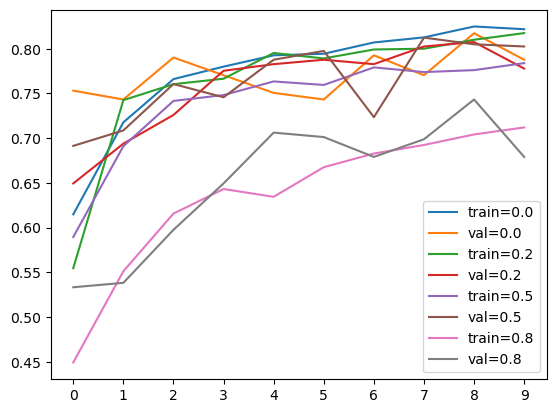

In [ ]:
for droprate, hist in scores.items():
    plt.plot(hist["categorical_accuracy"], label=(f"train={droprate}"))
    plt.plot(hist["val_categorical_accuracy"], label=(f"val={droprate}"))

plt.xticks(np.arange(10))
plt.legend()

In [ ]:
# del scores[0.8] #poor performance

colors = ["red", "blue", "green"]

for i, (droprate, hist) in enumerate(scores.items()):
    plt.plot(hist["categorical_accuracy"], label=(f"train={droprate}"), color=colors[i])
    plt.plot(
        hist["val_categorical_accuracy"],
        linestyle="dashed",
        label=(f"val={droprate}"),
        color=colors[i],
    )

plt.xticks(np.arange(10))
plt.legend()
plt.show()

***Best Hyperparameters so far:***
- learning_rate = 0.001
- droprate = 0.2 (I might try 0.1 later)

**2.0 Build multiple `Pre-trained Model (EfficientNetv2)` with different hyperparameters**

> Not Done yet 

In [ ]:
# Load the EfficientNetV2 pre-trained model from TensorFlow Hub, recommended input size is 240x240 pixels
module_url = (
    "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/classification/2"
)
model = get_trained_model(module_url)

# for tensorboard
log_dir = (
    "logs/fit/" + str(len(os.listdir("logs/eval")) + 1)
    if os.path.exists("logs/eval")
    else "logs/eval/1"
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# some parameters
EPOCHS = 10
BATCH_SIZE = 32

with tf.device("/device:GPU:0"):
    historyFit = model.fit(
        train_ds,
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[tensorboard_callback],
        batch_size=BATCH_SIZE,
    )


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              8212124   
                                                                 
 dense_3 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 8215127 (31.34 MB)
Trainable params: 8144055 (31.07 MB)
Non-trainable params: 71072 (277.62 KB)
_________________________________________________________________
Epoch 1/10
72/72 [==============================] - 53s 549ms/step - loss: 0.4617 - categorical_accuracy: 0.8523 - val_loss: 0.2005 - val_categorical_accuracy: 0.9309
Epoch 2/10
72/72 [==============================] - 26s 347ms/step - loss: 0.3139 - categorical_accuracy: 0.9085 - val_loss: 0.2490 - val_categorical_accuracy: 0.9333
Epoch 3/10
72/72 [==============================] - 26s 354ms/step - los

In [ ]:
evaluate(model, historyFit, test_ds)

NameError: name 'model' is not defined

In [ ]:
#lunch tensorboard to plot the results and the graphs
%tensorboard --logdir logs --port=6910